<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/CRYTPO_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ccxt pandas numpy ta-lib  -q
!pip install ta -q
#Install required packages
!pip install matplotlib seaborn -q

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
!ls  /content/gdrive/MyDrive/TradingBotLogs/trading_bot.db

/content/gdrive/MyDrive/TradingBotLogs/trading_bot.db


In [4]:
import sqlite3
import os
from google.colab import drive

# --- CONFIGURATION ---
DB_PATH = '/content/gdrive/MyDrive/TradingBotLogs/trading_bot.db'

# Ensure Drive is mounted to access the DB file
try:
    drive.mount('/content/gdrive', force_remount=True)
except:
    pass # Assume already mounted

REQUIRED_TABLES = [
    'candles',
    'technical_indicators',
    'trade_history',
    'cycle_performance',
    'asset_cycle_performance'
]

def verify_database_tables(db_path, required_tables):
    """
    Connects to the SQLite database and checks if all specified tables exist.
    """
    if not os.path.exists(db_path):
        print(f"❌ DATABASE FILE NOT FOUND at: {db_path}")
        print("ACTION: Ensure the trading bot has run at least once.")
        return

    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        missing_tables = []

        print(f"✅ Database file found at: {db_path}")
        print("-" * 40)

        for table in required_tables:
            # Query the sqlite_master table (the metadata table)
            cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table}'")
            if cursor.fetchone():
                print(f"🟢 FOUND: Table '{table}' exists.")
            else:
                print(f"🔴 MISSING: Table '{table}' is NOT present.")
                missing_tables.append(table)

        print("-" * 40)
        conn.close()

        if not missing_tables:
            print("🎉 SUCCESS: All required performance tables are present!")
        else:
            print("⚠️ WARNING: One or more tables required by the Performance Analyzer are missing.")

    except sqlite3.Error as e:
        print(f"❌ DATABASE ERROR: {e}")
        print("ACTION: Check file permissions or disk space.")

# --- EXECUTION ---
verify_database_tables(DB_PATH, REQUIRED_TABLES)

Mounted at /content/gdrive
✅ Database file found at: /content/gdrive/MyDrive/TradingBotLogs/trading_bot.db
----------------------------------------
🟢 FOUND: Table 'candles' exists.
🟢 FOUND: Table 'technical_indicators' exists.
🟢 FOUND: Table 'trade_history' exists.
🟢 FOUND: Table 'cycle_performance' exists.
🟢 FOUND: Table 'asset_cycle_performance' exists.
----------------------------------------
🎉 SUCCESS: All required performance tables are present!


## QA

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
🔄 Generating Performance Report...
✅ Performance tables verified

═════════════════════════📊 PERFORMANCE ANALYSIS REPORT ═════════════════════════
Generated: 2025-10-04 20:31:19.527881
════════════════════════════════════════════════════════════════════════════════

──────────────────────────📈 CYCLE PERFORMANCE SUMMARY ──────────────────────────
 cycle_number                        timestamp  portfolio_value  total_return_pct  max_drawdown_pct  sharpe_ratio  total_trades  winning_trades
            1 2025-10-04T05:40:23.935804-04:00      1000.000000          0.000000          0.000000      0.000000             0               0
            2 2025-10-04T06:46:56.031715-04:00      1000.000000          0.000000          0.000000     93.594872             0               0
            3 2025-10-04T07:48:48.508301-04:00      1000.000000          0.000000        

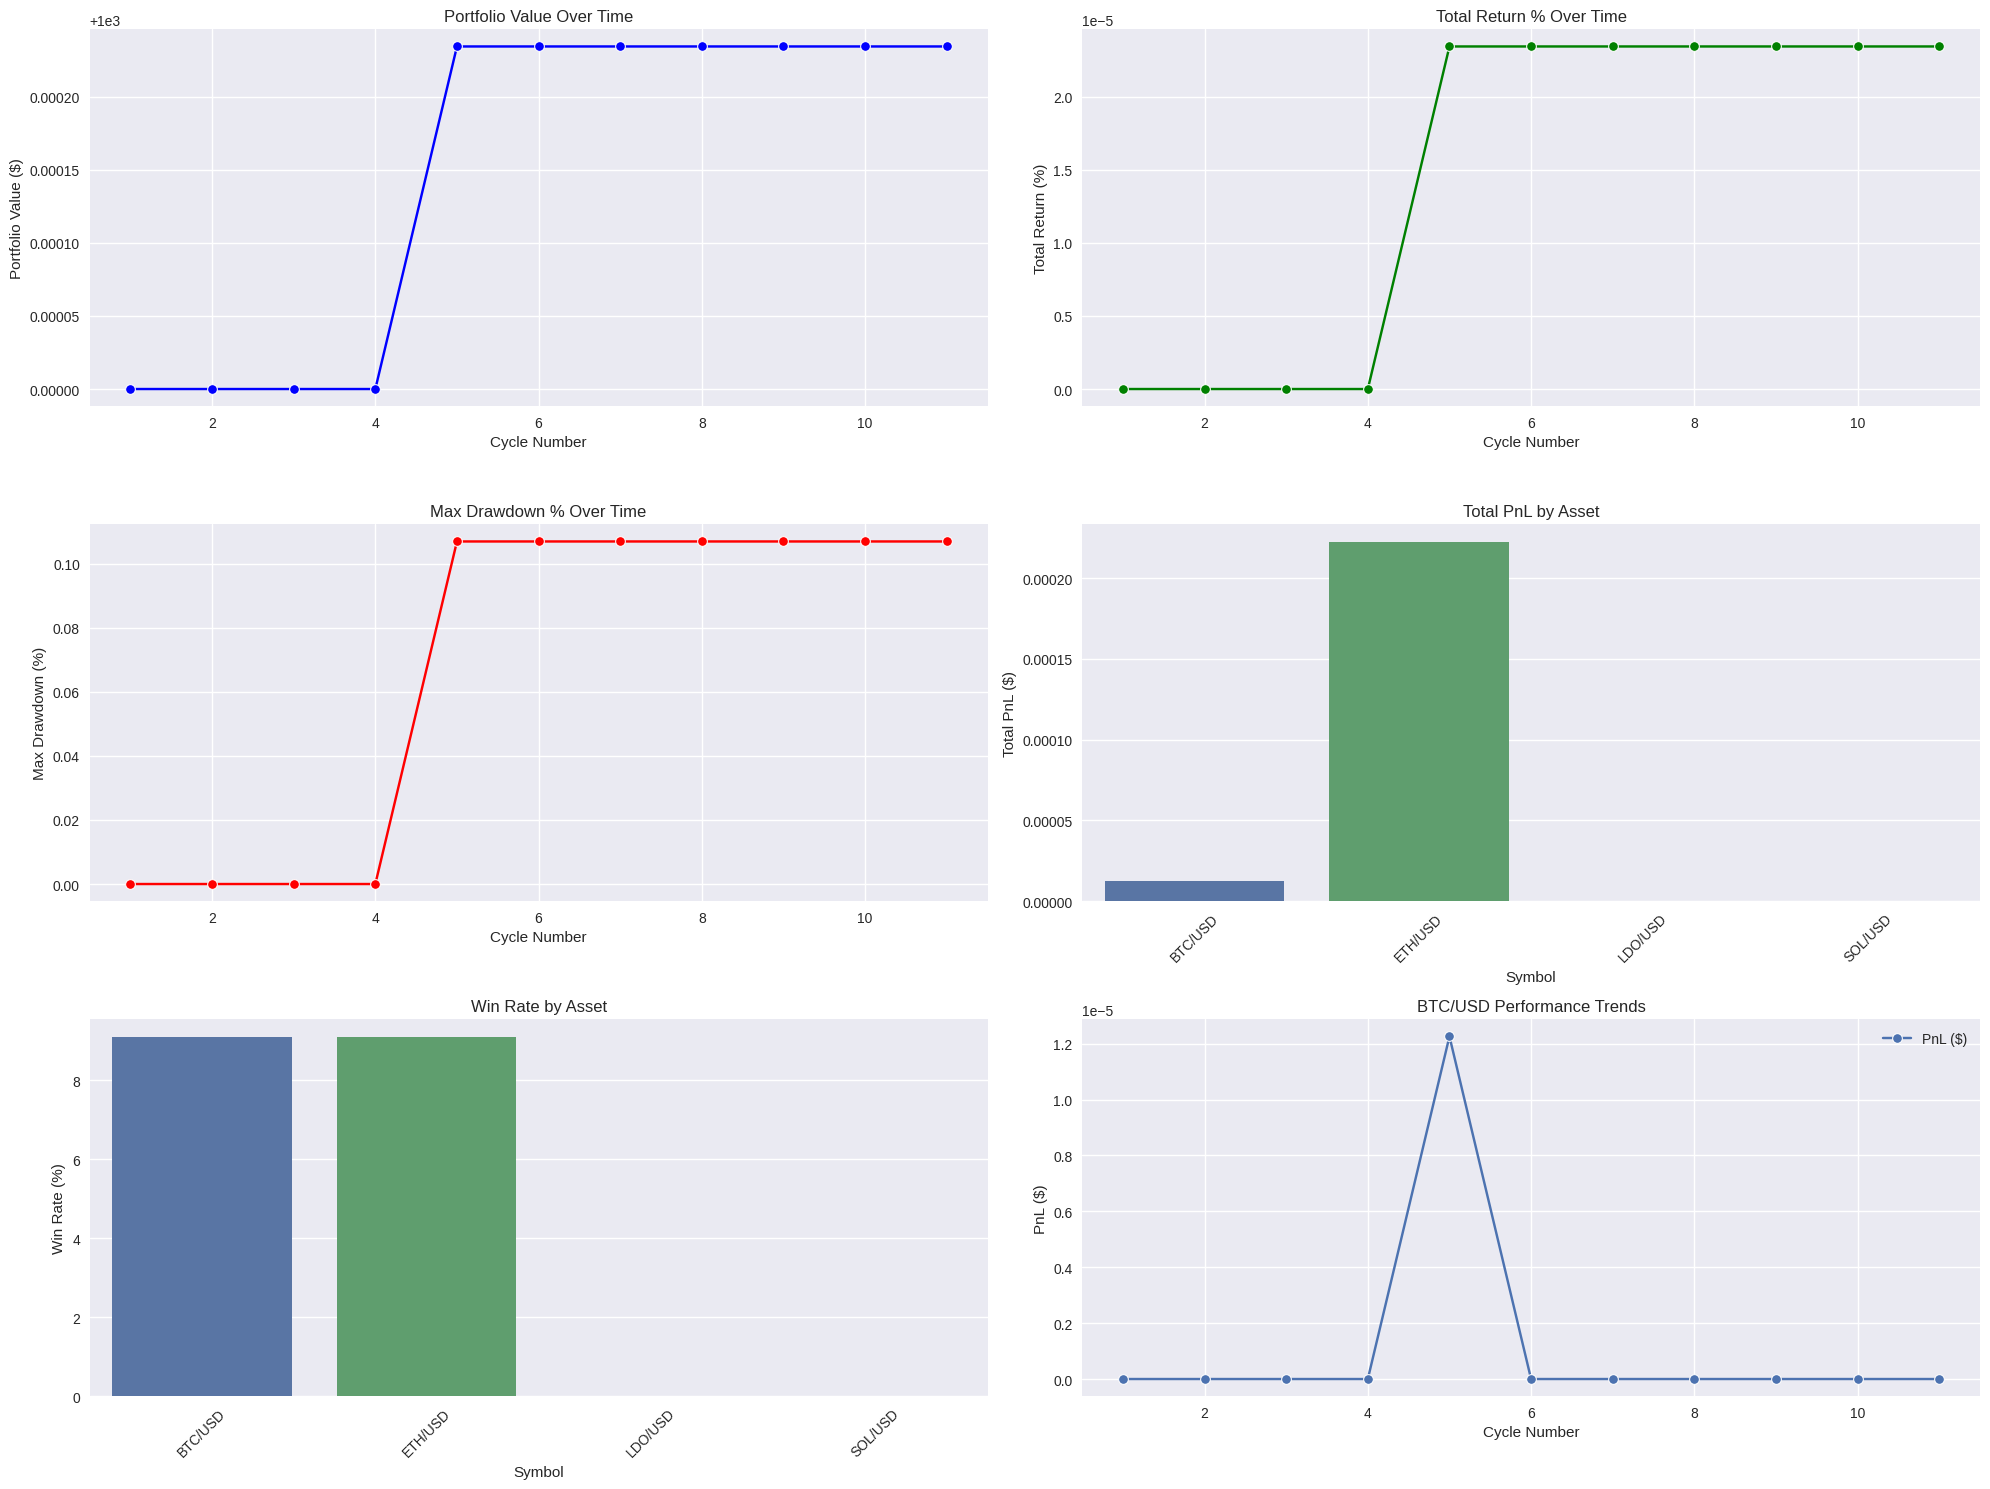

📈 Charts saved to /content/gdrive/MyDrive/TradingBotLogs/plots/performance_charts_cycle_range_1_to_latest_days_7.png

📊 Detailed Cycle Summary (Last 30 Days):
 cycle_number                        timestamp  portfolio_value  total_return_pct  max_drawdown_pct  sharpe_ratio  total_trades  winning_trades  total_pnl  runtime_hours
            1 2025-10-04T05:40:23.935804-04:00      1000.000000          0.000000          0.000000      0.000000             0               0   0.000000       0.112718
            2 2025-10-04T06:46:56.031715-04:00      1000.000000          0.000000          0.000000     93.594872             0               0   0.000000       1.143963
            3 2025-10-04T07:48:48.508301-04:00      1000.000000          0.000000          0.000000    120.447848             0               0   0.000000       2.169711
            4 2025-10-04T08:50:21.190855-04:00      1000.000000          0.000000          0.000000     89.823635             0               0   0.000000       

In [5]:


import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive
import numpy as np

# --- CONFIGURATION ---
DB_PATH = '/content/gdrive/MyDrive/TradingBotLogs/trading_bot.db'
PLOT_DIR = '/content/gdrive/MyDrive/TradingBotLogs/plots/'
drive.mount('/content/gdrive')
os.makedirs(PLOT_DIR, exist_ok=True)

class PerformanceAnalyzer:
    def __init__(self, db_path):
        """Initialize the analyzer with database connection"""
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path)
        self.plot_dir = PLOT_DIR

    def sync_performance_data(self):
        """Verify and sync performance data (placeholder for future extensions)"""
        try:
            cursor = self.conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='cycle_performance'")
            if not cursor.fetchone():
                print("⚠️ cycle_performance table doesn't exist")
                return False
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='asset_cycle_performance'")
            if not cursor.fetchone():
                print("⚠️ asset_cycle_performance table doesn't exist")
                return False
            print("✅ Performance tables verified")
            return True
        except Exception as e:
            print(f"❌ Error verifying performance tables: {e}")
            return False

    def get_cycle_performance_summary(self, start_cycle=None, end_cycle=None, days=None):
        """Generate summary of cycle performance"""
        query = """
        SELECT
            cycle_number,
            timestamp,
            portfolio_value,
            total_return_pct,
            max_drawdown_pct,
            sharpe_ratio,
            total_trades,
            winning_trades,
            total_pnl,
            runtime_hours
        FROM cycle_performance
        WHERE 1=1
        """
        params = []
        if start_cycle is not None:
            query += " AND cycle_number >= ?"
            params.append(start_cycle)
        if end_cycle is not None:
            query += " AND cycle_number <= ?"
            params.append(end_cycle)
        if days is not None:
            query += " AND datetime(timestamp) >= datetime('now', ?)"
            params.append(f'-{days} days')
        query += " ORDER BY cycle_number"

        return pd.read_sql_query(query, self.conn, params=params)

    def get_asset_performance_summary(self, start_cycle=None, end_cycle=None, days=None, symbols=None):
        """Generate summary of per-asset performance"""
        query = """
        SELECT
            symbol,
            COUNT(*) as total_trades,
            SUM(pnl) as total_pnl,
            AVG(pnl) as avg_pnl,
            SUM(CASE WHEN pnl > 0 THEN 1 ELSE 0 END) as winning_trades,
            AVG(CASE WHEN pnl > 0 THEN 1 ELSE 0 END) * 100 as win_rate
        FROM asset_cycle_performance
        WHERE 1=1
        """
        params = []
        if start_cycle is not None:
            query += " AND cycle_number >= ?"
            params.append(start_cycle)
        if end_cycle is not None:
            query += " AND cycle_number <= ?"
            params.append(end_cycle)
        if days is not None:
            query += " AND datetime(created_at) >= datetime('now', ?)"
            params.append(f'-{days} days')
        if symbols:
            symbols_str = ','.join('?' for _ in symbols)
            query += f" AND symbol IN ({symbols_str})"
            params.extend(symbols)
        query += " GROUP BY symbol"

        return pd.read_sql_query(query, self.conn, params=params)

    def get_performance_trends(self, symbol, days=30):
        """Track performance trends for a specific symbol over time"""
        query = """
        SELECT
            cycle_number,
            date(datetime(created_at)) as date,
            pnl,
            trades
        FROM asset_cycle_performance
        WHERE symbol = ?
        AND datetime(created_at) >= datetime('now', ?)
        GROUP BY cycle_number, date
        ORDER BY cycle_number
        """
        return pd.read_sql_query(query, self.conn, params=[symbol, f'-{days} days'])

    def generate_performance_report(self, start_cycle=None, end_cycle=None, days=7, symbols=None):
        """Generate comprehensive performance report"""
        self.sync_performance_data()

        report = {
            'timestamp': datetime.now(),
            'cycle_summary': self.get_cycle_performance_summary(start_cycle, end_cycle, days).to_dict('records'),
            'asset_summary': self.get_asset_performance_summary(start_cycle, end_cycle, days, symbols).to_dict('records'),
            'recommendations': []
        }

        # Add recommendations based on data
        cycle_summary = self.get_cycle_performance_summary(start_cycle, end_cycle, days)
        asset_summary = self.get_asset_performance_summary(start_cycle, end_cycle, days, symbols)

        if not cycle_summary.empty:
            latest_cycle = cycle_summary.iloc[-1]
            if latest_cycle['max_drawdown_pct'] > 10:
                report['recommendations'].append(
                    f"🔻 High drawdown ({latest_cycle['max_drawdown_pct']:.2f}%) in cycle {latest_cycle['cycle_number']} - review risk parameters"
                )
            if latest_cycle['sharpe_ratio'] < 1:
                report['recommendations'].append(
                    f"⚠️ Low Sharpe Ratio ({latest_cycle['sharpe_ratio']:.2f}) in cycle {latest_cycle['cycle_number']} - assess volatility"
                )
            if latest_cycle['total_return_pct'] > 20:
                report['recommendations'].append(
                    f"✅ Strong return ({latest_cycle['total_return_pct']:.2f}%) in cycle {latest_cycle['cycle_number']} - consider scaling"
                )

        for asset in report['asset_summary']:
            if asset['total_trades'] < 5:
                report['recommendations'].append(
                    f"⏳ {asset['symbol']}: Limited trades ({asset['total_trades']}) - collect more data"
                )
            elif asset['win_rate'] < 40:
                report['recommendations'].append(
                    f"🔻 {asset['symbol']}: Low win rate ({asset['win_rate']:.1f}%) - review trading strategy"
                )
            if asset['total_pnl'] < 0:
                report['recommendations'].append(
                    f"🔻 {asset['symbol']}: Negative PnL (${asset['total_pnl']:,.2f}) - check model performance"
                )
            if asset['win_rate'] > 60 and asset['total_pnl'] > 0:
                report['recommendations'].append(
                    f"🎯 {asset['symbol']}: Strong performer (Win Rate: {asset['win_rate']:.1f}%, PnL: ${asset['total_pnl']:,.2f})"
                )

        return report

    def create_performance_charts(self, start_cycle=None, end_cycle=None, days=7, symbols=None):
        """Generate visual performance charts"""
        os.makedirs(self.plot_dir, exist_ok=True)
        try:
            plt.style.use('seaborn-v0_8')  # Updated to valid style
        except:
            print("⚠️ 'seaborn-v0_8' style not available, using 'default'")
            plt.style.use('default')

        cycle_df = self.get_cycle_performance_summary(start_cycle, end_cycle, days)
        asset_df = self.get_asset_performance_summary(start_cycle, end_cycle, days, symbols)

        if cycle_df.empty or len(cycle_df) < 2:
            print("⚠️ Insufficient cycle performance data for charts (need at least 2 cycles)")
            return

        plt.figure(figsize=(20, 15))

        # 1. Portfolio Value Over Time
        plt.subplot(3, 2, 1)
        if not cycle_df.empty:
            sns.lineplot(data=cycle_df, x='cycle_number', y='portfolio_value', marker='o', color='blue')
            plt.title('Portfolio Value Over Time')
            plt.xlabel('Cycle Number')
            plt.ylabel('Portfolio Value ($)')
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'No cycle data', ha='center', va='center')
            plt.title('Portfolio Value Over Time')

        # 2. Total Return %
        plt.subplot(3, 2, 2)
        if not cycle_df.empty:
            sns.lineplot(data=cycle_df, x='cycle_number', y='total_return_pct', marker='o', color='green')
            plt.title('Total Return % Over Time')
            plt.xlabel('Cycle Number')
            plt.ylabel('Total Return (%)')
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'No cycle data', ha='center', va='center')
            plt.title('Total Return % Over Time')

        # 3. Max Drawdown %
        plt.subplot(3, 2, 3)
        if not cycle_df.empty:
            sns.lineplot(data=cycle_df, x='cycle_number', y='max_drawdown_pct', marker='o', color='red')
            plt.title('Max Drawdown % Over Time')
            plt.xlabel('Cycle Number')
            plt.ylabel('Max Drawdown (%)')
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'No cycle data', ha='center', va='center')
            plt.title('Max Drawdown % Over Time')

        # 4. Asset PnL Bar Chart
        plt.subplot(3, 2, 4)
        if not asset_df.empty:
            sns.barplot(data=asset_df, x='symbol', y='total_pnl', hue='symbol')
            plt.title('Total PnL by Asset')
            plt.xlabel('Symbol')
            plt.ylabel('Total PnL ($)')
            plt.xticks(rotation=45)
            plt.grid(True, axis='y')
        else:
            plt.text(0.5, 0.5, 'No asset data', ha='center', va='center')
            plt.title('Total PnL by Asset')

        # 5. Win Rate by Asset
        plt.subplot(3, 2, 5)
        if not asset_df.empty:
            sns.barplot(data=asset_df, x='symbol', y='win_rate', hue='symbol')
            plt.title('Win Rate by Asset')
            plt.xlabel('Symbol')
            plt.ylabel('Win Rate (%)')
            plt.xticks(rotation=45)
            plt.grid(True, axis='y')
        else:
            plt.text(0.5, 0.5, 'No asset data', ha='center', va='center')
            plt.title('Win Rate by Asset')

        # 6. Asset Performance Trends (example with BTC/USD)
        plt.subplot(3, 2, 6)
        try:
            btc_trends = self.get_performance_trends('BTC/USD', days=days)
            if not btc_trends.empty and len(btc_trends) >= 2:
                sns.lineplot(data=btc_trends, x='cycle_number', y='pnl', marker='o', label='PnL ($)')
                plt.title('BTC/USD Performance Trends')
                plt.xlabel('Cycle Number')
                plt.ylabel('PnL ($)')
                plt.grid(True)
                plt.legend()
            else:
                plt.text(0.5, 0.5, 'Insufficient BTC/USD data', ha='center', va='center')
                plt.title('BTC/USD Performance Trends')
        except:
            plt.text(0.5, 0.5, 'Error loading trends', ha='center', va='center')
            plt.title('BTC/USD Performance Trends')

        plt.tight_layout()
        cycle_range = f'cycle_range_{start_cycle or 1}_to_{end_cycle or "latest"}_days_{days}'
        plot_path = os.path.join(self.plot_dir, f'performance_charts_{cycle_range}.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📈 Charts saved to {plot_path}")

    def print_detailed_report(self, start_cycle=None, end_cycle=None, days=7, symbols=None):
        """Print detailed performance report to console"""
        report = self.generate_performance_report(start_cycle, end_cycle, days, symbols)

        print(f"\n{'📊 PERFORMANCE ANALYSIS REPORT ':═^80}")
        print(f"Generated: {report['timestamp']}")
        print(f"{'':═^80}")

        print(f"\n{'📈 CYCLE PERFORMANCE SUMMARY ':─^80}")
        cycle_df = pd.DataFrame(report['cycle_summary'])
        if not cycle_df.empty:
            print(cycle_df[['cycle_number', 'timestamp', 'portfolio_value', 'total_return_pct',
                            'max_drawdown_pct', 'sharpe_ratio', 'total_trades', 'winning_trades']].to_string(index=False))
        else:
            print("⚠️ No cycle data available")

        print(f"\n{'📈 ASSET PERFORMANCE SUMMARY ':─^80}")
        asset_df = pd.DataFrame(report['asset_summary'])
        if not asset_df.empty:
            print(asset_df[['symbol', 'total_trades', 'winning_trades', 'win_rate', 'total_pnl', 'avg_pnl']].to_string(index=False))
        else:
            print("⚠️ No asset data available")

        print(f"\n{'🎯 RECOMMENDATIONS ':─^80}")
        for rec in report['recommendations']:
            print(f"   {rec}")
        if not report['recommendations']:
            print("   ✅ No major issues detected")

    def close(self):
        """Close database connection"""
        if self.conn:
            self.conn.close()

def run_performance_analysis(start_cycle=None, end_cycle=None, days=7, symbols=None):
    """Run comprehensive performance analysis"""
    analyzer = PerformanceAnalyzer(DB_PATH)
    try:
        print("🔄 Generating Performance Report...")
        analyzer.print_detailed_report(start_cycle, end_cycle, days, symbols)

        print("🔄 Creating Performance Charts...")
        analyzer.create_performance_charts(start_cycle, end_cycle, days, symbols)

        print("\n📊 Detailed Cycle Summary (Last 30 Days):")
        summary = analyzer.get_cycle_performance_summary(days=30)
        print(summary.to_string(index=False))

        print("\n📊 Detailed Asset Summary (Last 30 Days):")
        asset_summary = analyzer.get_asset_performance_summary(days=30, symbols=symbols)
        print(asset_summary.to_string(index=False))
    except Exception as e:
        print(f"❌ Error in performance analysis: {e}")
    finally:
        analyzer.close()

# Run the analysis
if __name__ == "__main__":
    run_performance_analysis()  # Analyze all data
    # Example with specific parameters:
    # run_performance_analysis(start_cycle=1, end_cycle=10, days=7, symbols=['BTC/USD', 'LDO/USD'])